First:
- go to the terminal
- go to the `4_tuning_networks` folder, use `cd` to get there, or `z` to get there faster.
- if you are planning on closing the laptop to let this run by itself, start a tmux session by giving the command `tmux`. You can name the session with `ctrl+b $`, leave the tmux with `ctrl+b` d, access it again with `tmux a -t 0` or replace the 0 with the name you gave it. See [tmux](https://github.com/tmux/tmux/wiki/Getting-Started) for more info.
- Activate the `.venv`, and run `python hypertune.py`
- In the hypertune.py file, a tune_dir is specified: `models/ray`. We will check the contents of that folder after the hypertune finished. You can also use tensorboard to check the results. 
- this will take some time. I clocked 1901 seconds (30 minutes) on the VM

 0.0992908 |           119 |            3 |     26 |         576.744  |    0 |   0.942187

In [37]:
from pathlib import Path
tune_dir = Path("../models/ray").resolve()
tune_dir.exists()

True

In [38]:
tunelogs = [d for d in tune_dir.iterdir()]
tunelogs.sort()
latest = tunelogs[-4]
latest

PosixPath('/home/azureuser/code/mads-exam-24-FalcovdHoogen/models/ray/train_2024-06-30_12-38-58')

In [39]:
from ray.tune import ExperimentAnalysis
import ray
ray.init(ignore_reinit_error=True)


analysis = ExperimentAnalysis(latest)


2024-07-04 06:09:18,475	INFO worker.py:1586 -- Calling ray.init() again after it has already been called.


2024-07-04 06:09:18,759	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_eaf5e51b: RuntimeError('Should not access `trial_fs_path` without setting `trial_dir_name`')


So, we find some info:

In [40]:
analysis.results_df.columns


Index(['iterations', 'train_loss', 'test_loss', 'Accuracy', 'F1scoremicro',
       'F1scoremacro', 'Precisionmicro', 'Recallmacro', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/hidden', 'config/num_layers', 'config/tune_dir',
       'config/data_dir', 'config/num_classes', 'config/dropout_rate',
       'config/shape'],
      dtype='object')

Let's focus on the parameters we wanted to tune.

In [41]:
import plotly.express as px

plot = analysis.results_df
select = ["Recallmacro", "iterations", 'config/num_layers', "config/hidden", "config/dropout_rate"]
p = plot[select].reset_index().dropna()


Let's sort by accuracy

In [42]:
p.sort_values("Recallmacro", inplace=True)

Make a parallel plot

In [43]:
px.parallel_coordinates(p, color="Recallmacro")


<Axes: xlabel='config/hidden', ylabel='config/dropout_rate'>

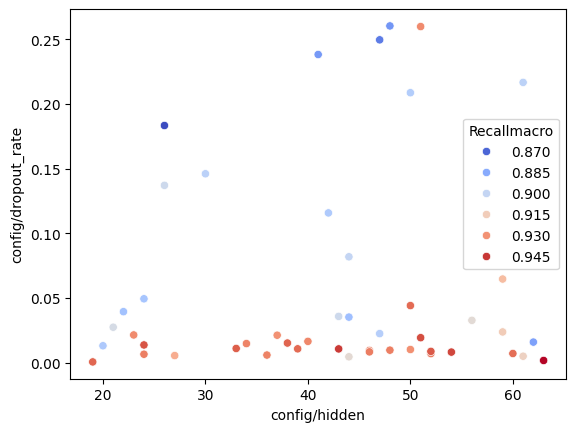

In [44]:
import seaborn as sns

sns.scatterplot(data=p, x="config/hidden", y="config/dropout_rate", hue="Recallmacro", palette="coolwarm")

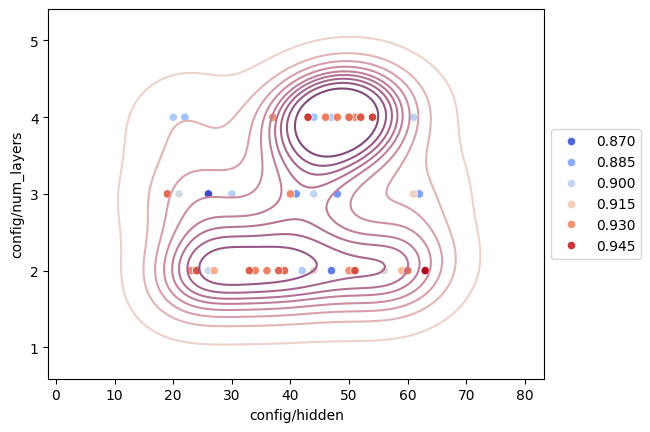

In [45]:
import matplotlib.pyplot as plt
cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(data=p, x="config/hidden", y="config/num_layers", hue="Recallmacro", palette="coolwarm")
sns.kdeplot(data=p, x="config/hidden", y="config/num_layers", cmap=cmap)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

Get the best trial

In [46]:
analysis.get_best_trial(metric="Recallmacro", mode="max")


train_9a220f74

The top ten

In [47]:
p[-10:]


,trial_id,Recallmacro,iterations,config/num_layers,config/hidden,config/dropout_rate
40,f71f9208,0.937358,4.0,2.0,39.0,0.010795
42,a3b4a354,0.937912,4.0,3.0,19.0,0.000673
21,d353642b,0.938451,4.0,2.0,38.0,0.015271
24,2a6f4f47,0.939241,2.0,2.0,33.0,0.011072
36,ff18cee7,0.940131,4.0,4.0,52.0,0.008812
37,40dd593c,0.941131,4.0,2.0,24.0,0.013787
7,2f4ef102,0.942107,6.0,2.0,51.0,0.019401
46,b4779f79,0.943148,4.0,4.0,54.0,0.008274
44,a251b1d9,0.944678,4.0,4.0,43.0,0.010728
14,9a220f74,0.949778,6.0,2.0,63.0,0.001791


Or the best config

In [48]:
analysis.get_best_config(metric="Accuracy", mode="max")


{'hidden': 51,
 'num_layers': 2,
 'tune_dir': PosixPath('/home/azureuser/code/mads-exam-24-FalcovdHoogen/models/ray'),
 'data_dir': PosixPath('/home/azureuser/code/mads-exam-24-FalcovdHoogen/data'),
 'num_classes': 5,
 'dropout_rate': 0.019400987205563158,
 'shape': [16, 12]}